In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn.datasets as datasets
from tqdm import tqdm
import torch
device = torch.device('cuda')
torch.set_default_tensor_type('torch.cuda.FloatTensor') if torch.cuda.is_available() else print ('cpu')
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as utils


## Change the line below this to point to the directory where you have cloned the nflows paclage

sys.path.append("/home/sambt/CASE_final/CASE_QUAK_final/")
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal, ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def make_flow(num_features,num_context,kwargs,perm=True):
    base_dist = StandardNormal(shape=[num_features])
    transforms = []
    if num_context == 0:
        num_context = None
    for i in range(kwargs['num_layers']):
        transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=num_features,
                                                                                context_features=num_context,
                                                                                hidden_features=kwargs['hidden_features'],
                                                                                num_bins=kwargs['num_bins'],
                                                                                num_blocks=kwargs['num_blocks_per_layer'],
                                                                                tail_bound=kwargs['tail_bound'], 
                                                                                tails=kwargs['tails'],
                                                                                dropout_probability=kwargs['dropout'] if 'dropout' in kwargs.keys() else 0,
                                                                                use_batch_norm=kwargs['batchnorm'] if 'batchnorm' in kwargs.keys() else False))
            
        
        if i < kwargs['num_layers'] - 1 and perm:
            transforms.append(ReversePermutation(features=num_features))

    transform = CompositeTransform(transforms)
    flow = Flow(transform, base_dist)
    return flow

class InfiniteLoader(utils.DataLoader):
    """A data loader that can load a dataset repeatedly."""

    def __init__(self, num_epochs=None, *args, **kwargs):
        """Constructor.

        Args:
            dataset: A `Dataset` object to be loaded.
            batch_size: int, the size of each batch.
            shuffle: bool, whether to shuffle the dataset after each epoch.
            drop_last: bool, whether to drop last batch if its size is less than
                `batch_size`.
            num_epochs: int or None, number of epochs to iterate over the dataset.
                If None, defaults to infinity.
        """
        super().__init__(
            *args, **kwargs
        )
        self.finite_iterable = super().__iter__()
        self.counter = 0
        self.num_epochs = float('inf') if num_epochs is None else num_epochs

    def __next__(self):
        try:
            return next(self.finite_iterable)
        except StopIteration:
            self.counter += 1
            if self.counter >= self.num_epochs:
                raise StopIteration
            self.finite_iterable = super().__iter__()
            return next(self.finite_iterable)

    def __iter__(self):
        return self

    def __len__(self):
        return None
                                                                                  
def train_flow(flow,data,context=None,n_epoch=20,lr=1e-3,bs=256,wd=0.0,patience=-1,n_avg=100,anneal=True):
    flow = flow.to(device)
    if wd>0:
        optimizer = optim.AdamW(flow.parameters(),lr=lr,weight_decay=wd)
    else:
        optimizer = optim.AdamW(flow.parameters(),lr=lr)
        
    n_iter = n_epoch*data.shape[0]//bs
    if anneal:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=n_iter,eta_min=lr,verbose=False)
    
    if context is None: # only used if you are training a conditional normalizing flow, in which case the context input is the conditioning variables
        dataset = utils.TensorDataset(torch.tensor(data,dtype=torch.float32,device=device))
    else:
        dataset = utils.TensorDataset(torch.tensor(data,dtype=torch.float32,device=device),torch.tensor(context,dtype=torch.float32,device=device))
    loader = InfiniteLoader(dataset=dataset,batch_size=bs,shuffle=True,generator=torch.Generator(device=device))

    min_loss = 1e+8
    train_losses = []
    patience_count = 0
    bestState = None

    print("Training flow")

    tbar = tqdm(range(n_iter))
    avg_losses = []
    for i in tbar:
        if patience_count == patience:
            break
        optimizer.zero_grad()
        if context is None:
            x, = next(loader)
            loss = -flow.log_prob(inputs=x)[0].mean()
        else:
            x,y = next(loader)
            loss = -flow.log_prob(inputs=x,context=y)[0].mean()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if loss.item() < min_loss:
            min_loss = loss.item()
            bestState = flow.state_dict()
            patience_count=0
        else:
            patience_count +=1
        avg_losses.append(loss.item())
        if i+1 > n_avg:
            avg_losses = avg_losses[1:]
        l_print = np.mean(avg_losses)
        s = 'Loss: {0}, p = {1}'.format(l_print,patience_count)
        tbar.set_description(s)
        if anneal:
            scheduler.step()

    flow.load_state_dict(bestState)
    flow.eval()
    del dataset, loader, optimizer
    torch.cuda.empty_cache()
    flow = flow.to('cpu')
    
    plt.figure(figsize=(8,6))
    w = int(data.shape[0]/(5*bs))
    smooth = np.convolve(np.ones(w),train_losses,mode='valid')/w
    xvals = np.linspace(0,len(train_losses),len(smooth))
    plt.plot(xvals,smooth)

    return flow

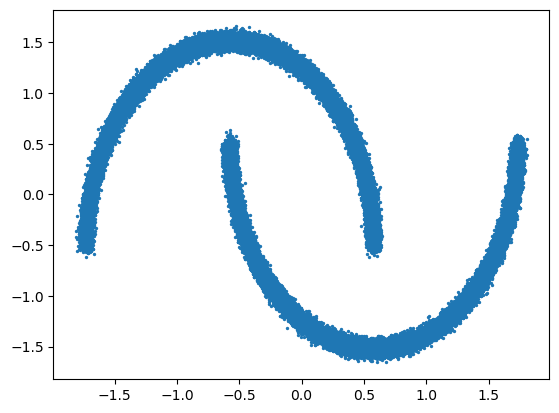

In [4]:
train,l1 = datasets.make_moons(100000,noise=0.02)
test,l2 = datasets.make_moons(100000,noise=0.02)

train = (train-train.mean(axis=0))/train.std(axis=0)
test = (test-test.mean(axis=0))/test.std(axis=0)

plt.scatter(train[:,0],train[:,1],s=2)

The flows I've been using from `nflows` are "Autoregressive Piecewise Rational Quadratic Splines" (for details, you can find the paper here: https://arxiv.org/abs/1906.04032). In essence, each flow layer is a spline transformation whose parameters are determined by an autoregressive neural network. At each step, the input $\mathbf{x} = (x_1,x_2,\ldots,x_k)$ is transformed to $\mathbf{x}^\prime = (f_{\phi_1}(x_1), f_{\phi_2(x_1)}(x_2), f_{\phi_3(x_1,x_2}(x_3), \ldots)$. The parameters $\phi_1$, $\phi_2(x_1)$, etc. parametrize the spline transformation $f$ applied to each input variable, and are defined **autoregressively**, meaning that the transformation parameters for variable $x_i$ depend on $x_1,x_2,\ldots,x_{i-1}$. This makes the Jacobian of the transformation well-behaved (lower triangular) and tractable to calculate.

The basic parameters for a spline flow layer are:
1. `tail_bound` = the range over which the spline transformation is defined. A tail bound of 3 would mean that the spline maps from the interval $[-3,3] \to [-3,3]$. 
2. `num_bins` = the number of bins that the interval `[-tail_bound,tail_bound]` gets chopped into for the spline transformation (see paper for more details)
3. `hidden_features` = number of hidden units in the neural network that calculates the spline parameters
4. `num_blocks_per_layer` = number of hidden layers in the neural network that calculates the spline parameters
5. `tails` = how inputs that fall outside the range `[-tail_bound,tail_bound]` are treated. I always use `tails = "linear"`, which just does a linear extrapolation of the spline from the interval boundary

In [5]:
flow_kwargs = {"num_layers":5, # total number of flow layers
               "tail_bound":3.5,"num_bins":15, # network parameters for each layer of spline transformations
               "hidden_features":100,"num_blocks_per_layer":5,"tails":"linear"} # network parameters for each layer of spline transformations
flow = make_flow(2,num_context=0,kwargs=flow_kwargs,perm=True)

Training flow


Loss: 0.32362504467368125, p = 506: 100%|██████████| 976/976 [01:15<00:00, 12.95it/s]


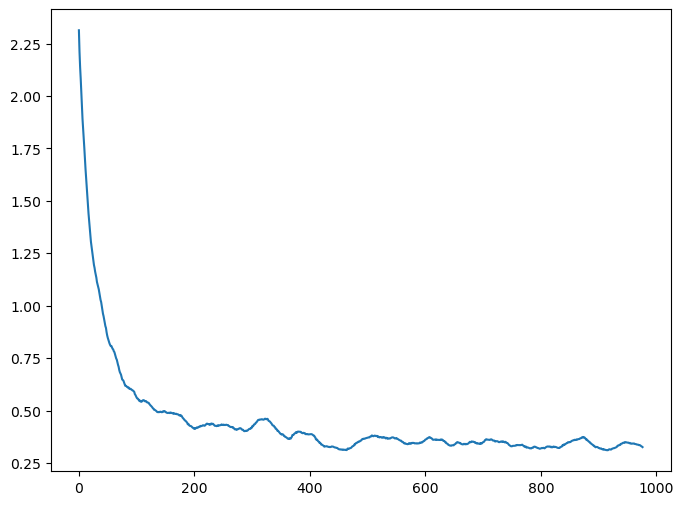

In [6]:
flow = flow.to(device)
flow = train_flow(flow,train,context=None,n_epoch=5,lr=1e-3,bs=512,wd=0.0,patience=-1,n_avg=100,anneal=True)

(-2.0, 2.0)

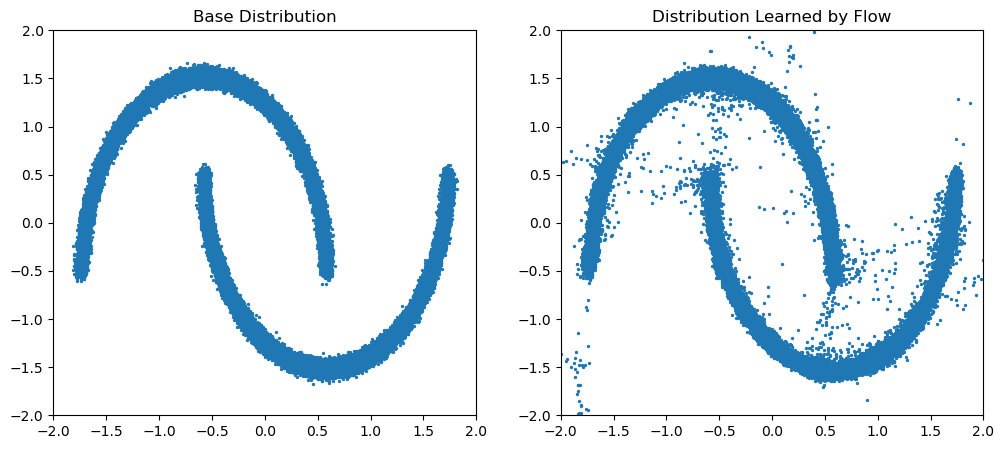

In [7]:
flow = flow.to(device)
with torch.no_grad():
    samples = flow.sample(100000).cpu().numpy()
fig,axes = plt.subplots(1,2,figsize=(12,5))

plt.sca(axes[0])
plt.scatter(test[:,0],test[:,1],s=2)
plt.title("Base Distribution")
plt.xlim([-2,2])
plt.ylim([-2,2])

plt.sca(axes[1])
plt.scatter(samples[:,0],samples[:,1],s=2)
plt.title("Distribution Learned by Flow")
plt.xlim([-2,2])
plt.ylim([-2,2])